# Advanced research assistant

### Basic imports and setting up OpenAI and Tavily integration

In [13]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0,
)

tools = [TavilySearchResults(max_results=5)]

### Defining the prompts for each agent role

In [14]:
search_template = """Your job is to search the web for stock market related news that would be relevant to to generate the article described by the user.

                     NOTE: When providing the news articles retrieved to the Outliner, you need to give the Outliner all of the articles you have retrieved that are relevant.
                     The format should be:

                     1. <article 1>
                     2. <article 2>
                     ...
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article. This means you are giving clear instructions what information should be included in the article in bullet point format as well as
                       the sources to include in the article.
                    """

writer_template = """Your job is to write an article, do it in this format:

                        TITLE: <title>
                        BODY: <body>

                    You may received feedback on the article from an editor. If you do receive feedback, you MUST make changes to your article and incorporate the feedback.

                       ```
                    """

editor_template = """Your job is to edit an article written by a writer. Please provide constructive critiques so they can improve it for publication.

                    ```EDITORIAL GUIDELINES TO FOLLOW```

                      - Your feedback should be in bullet point format only.

                      - The critiques should only focus on are the use of keywords, the title of the article, and the title of the headers, also make sure they include references.

                      - DO NOT not give positive feedback.

                      - DO NOT WRITE THE ARTICLE. You should only provide feedback in bullet point format.

                      - You should NEVER accept the first draft of the article.


                     If you think the article looks good, then simply say DONE.
                    """

### Constructing the graph

In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define method for creating agents and binding them to the tools
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm
    
search_agent = create_agent(
    llm,
    tools,
    system_message=search_template,
)

outliner_agent = create_agent(
    llm,
    [],
    system_message=outliner_template,
)

writer_agent = create_agent(
    llm,
    [],
    system_message=writer_template,
)

editor_agent = create_agent(
    llm,
    [],
    system_message=editor_template,
)

In [16]:
import functools

def agent_node(state, agent, name):
  result = agent.invoke(state)
  return {
      'messages': [result]
  }

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")

def editor_node(state):
  result = editor_agent.invoke(state)
  N = state["no_of_iterations"] + 1
  return {
      "messages": [result],
      "no_of_iterations": N
  }

In [17]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph import END, StateGraph


def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "outliner"

def should_edit(state) -> Literal["writer", END]:
  messages = state['messages']
  print("Iteration number from should_edit: ", state['no_of_iterations'])
  last_message = messages[-1]

  if 'DONE' in last_message.content or state['no_of_iterations']>=MAX_ITERATIONS:
    return END

  return "writer"

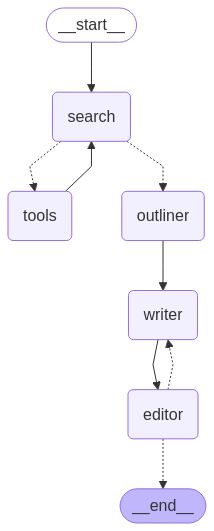

In [18]:
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  no_of_iterations: int

workflow = StateGraph(AgentState)

tool_node = ToolNode(tools)

# Add the nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)
workflow.add_node("editor", editor_node)

# Set the entrypoint as `search`
# This means that this node is the first one called
workflow.set_entry_point("search")
# Add the edges
workflow.add_conditional_edges(
    "search",
    should_search,
)
workflow.add_edge("tools", 'search')
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", "editor")
workflow.add_conditional_edges(
    "editor",
    should_edit
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

### Running and testing the implementation 

In [19]:
from langchain_core.messages import HumanMessage

MAX_ITERATIONS = 3

question = "What is the business potential of using generative technologies in investment banking? Propose usecases and business justficiation for them."

input_message = HumanMessage(content=question)

for event in graph.stream({"messages": [input_message], "no_of_iterations":0}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the business potential of using generative technologies in investment banking? Propose usecases and business justficiation for them.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3AlHGMU9ce6q0CDjAEX0HFlR)
 Call ID: call_3AlHGMU9ce6q0CDjAEX0HFlR
  Args:
    query: generative technologies in investment banking use cases business potential
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Generative AI in Banking: Practical Use Cases and Future Potential", "url": "https://www.trinetix.com/insights/generative-ai-in-banking", "content": "While traditional machine learning and artificial intelligence have demonstrated efficiency across various aspects of financial management and banking, generative AI stands out as a true game changer for the indu

## LLMOps monitoring using Langsmith

In [20]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv(override=True)
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0,
)

In [21]:
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.arxiv import ArxivAPIWrapper

# Initialize utilities
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
tavily = TavilySearchResults(max_results=5) 
# Add all tools
tools = [
    tavily,
    wikipedia,
    arxiv,
]

In [ ]:
import functools
from typing import Annotated, Literal, TypedDict
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults

# importing tools
tools = [TavilySearchResults(max_results=5)]

def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "{system_message}"),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    return prompt | (llm.bind_tools(tools) if tools else llm)

search_agent = create_agent(llm, tools, search_template)
outliner_agent = create_agent(llm, [], outliner_template)
writer_agent = create_agent(llm, [], writer_template)
editor_agent = create_agent(llm, [], editor_template)

# Dekorator @traceable - potrzebny w przypadku wielu agentów -> funkcji agentowych
@traceable(name="Agent Node")
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [result]
    }

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")

# Dekorator @traceable - potrzebny w przypadku wielu agentów -> funkcji agentowych
@traceable(name="Critic Node")
def editor_node(state):
    result = editor_agent.invoke(state)
    N = state["no_of_iterations"] + 1
    return {
        "messages": [result],
        "no_of_iterations": N
    }

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    no_of_iterations: int

def should_search(state) -> Literal["tools", "outliner"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "outliner"

def should_edit(state) -> Literal["writer", END]:
    messages = state["messages"]
    last_message = messages[-1]
    print("Iteration number from should_edit:", state["no_of_iterations"])
    if "DONE" in last_message.content or state["no_of_iterations"] >= MAX_ITERATIONS:
        return END
    return "writer"

In [23]:
# Implementing the grph
workflow = StateGraph(AgentState)
tool_node = ToolNode(tools)

workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)
workflow.add_node("editor", editor_node)

workflow.set_entry_point("search")
workflow.add_conditional_edges("search", should_search)
workflow.add_edge("tools", "search")
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", "editor")
workflow.add_conditional_edges("editor", should_edit)

graph = workflow.compile()


In [24]:
from langchain_core.messages import HumanMessage

MAX_ITERATIONS = 3

question = "What is the the current state of reasearch in the field of nuclear fusion?"

input_message = HumanMessage(content=question)

for event in graph.stream({"messages": [input_message], "no_of_iterations":0}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the the current state of reasearch in the field of nuclear fusion?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_UkYQwcxMX42okMV2yc9USoaf)
 Call ID: call_UkYQwcxMX42okMV2yc9USoaf
  Args:
    query: current state of research in nuclear fusion 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "IAEA Annual Report for 2023: Fusion Energy", "url": "https://www.iaea.org/publications/reports/annual-report/2023/in-focus/fusion-energy", "content": "The International Atomic Energy Agency (IAEA) fosters the exchange of scientific and technical results in nuclear fusion research and development through its series of Fusion Energy Conferences. The 29th Fusion Energy Conference (FEC 2023) aims to provide a forum for the discussion of key physics and t